# Social Network Analysis

In [3]:
import traceback
#from google.colab import drive
import random

# Recommender Systems (RS)
import pandas as pd
import numpy as np

import pickle
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from surprise import Reader, Dataset
from surprise import NormalPredictor, BaselineOnly, NMF, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, SVDpp, SlopeOne, CoClustering
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.accuracy import rmse
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

from scipy.sparse import csr_matrix
from collections import defaultdict

from sklearn.metrics import ndcg_score

In [4]:
# Social Network Analysis (SNA)
from itertools import combinations
from igraph import Graph, plot, RainbowPalette

## Data Initialization

In [5]:
df_rs_all = pd.read_csv('/Users/mac/Downloads/ADC-MECD/data/Philadelphia_reviews.csv')
df_rs_all.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'restaurant_name', 'address', 'city', 'state',
       'attributes', 'categories', 'latitude', 'longitude', 'is_open', 'year',
       'sentiment', 'text_length_before_clean', 'cleaned_text',
       'cleaned_text_stopwords_removed'],
      dtype='object')

In [6]:
mtrx_train_ratings= pd.read_csv('/Users/mac/Downloads/ADC-MECD/data/user_item_matrix.csv')

In [7]:
mtrx_train_ratings

user_id  17 Snyder Chinese  4 Seasons Food Market  \
0     --pMssoWlOqX0pLiPMiZZw                NaN                    NaN   
1     -00kdEIhCt-ODaV4BS-EAg                NaN                    NaN   
2     -0aZWYi2YicFaLxTru96nA                NaN                    NaN   
3     -2Pn4YRNRgJM8foLYkkv7g                NaN                    NaN   
4     -2_eYCiY4JXD_hUI2_HK6w                NaN                    NaN   
...                      ...                ...                    ...   
5911  zvq6qxc2IVA08jaUelUMRw                NaN                    NaN   
5912  zwCVNO9Kkv6-XqRnNliKgQ                NaN                    NaN   
5913  zwCkk1Pd88uZpvIQRRFo-A                NaN                    NaN   
5914  zx43prq7t59Bg5xDOm1t3g                NaN                    NaN   
5915  zziJLt25YU6dp01sewR-IQ                NaN                    NaN   

      A P J Texas Weiner  Abyssinia  Al's Italiano Pizzeria & Ristorante  \
0                    NaN        NaN                                  NaN   
1                    NaN        NaN                                  NaN   
2                    NaN        NaN                                  NaN   
3                    NaN        NaN                                  NaN   
4                    NaN        NaN                                  NaN   
...                  ...        ...                                  ...   
5911                 NaN        NaN                                  NaN   
5912                 NaN        NaN                                  NaN   
5913                 NaN        NaN                                  NaN   
5914                 NaN        NaN                                  NaN   
5915                 NaN        NaN                                  NaN   

      Allegro Pizza  Alyan's Restaurant  Amada  Amuse  ...  Winnie's Manayunk  \
0               NaN                 NaN    NaN    NaN  ...                NaN   
1               NaN                 NaN    NaN    NaN  ...                NaN   
2               NaN                 NaN    NaN    NaN  ...                NaN   
3               NaN                 NaN    NaN    NaN  ...                NaN   
4               NaN                 NaN    NaN    NaN  ...                NaN   
...             ...                 ...    ...    ...  ...                ...   
5911            NaN                 5.0    NaN    NaN  ...                NaN   
5912            NaN                 NaN    NaN    NaN  ...                NaN   
5913            NaN                 NaN    NaN    NaN  ...                NaN   
5914            NaN                 NaN    NaN    NaN  ...                NaN   
5915            NaN                 NaN    NaN    NaN  ...                NaN   

      Wokano  Wolf Street Pizza & Grill  Xochitl  Yards Brewing Company  \
0        NaN                        NaN      NaN                    NaN   
1        NaN                        NaN      NaN                    NaN   
2        NaN                        NaN      NaN                    NaN   
3        NaN                        NaN      NaN                    NaN   
4        NaN                        NaN      NaN                    NaN   
...      ...                        ...      ...                    ...   
5911     NaN                        NaN      NaN                    NaN   
5912     NaN                        NaN      NaN                    NaN   
5913     NaN                        NaN      NaN                    NaN   
5914     NaN                        NaN      NaN                    NaN   
5915     NaN                        NaN      NaN                    NaN   

      Zaffron  Zahav  Zaika  Zio Pizza Palace & Grill  Zorba's Taverna  
0         NaN    NaN    NaN                       NaN              NaN  
1         NaN    NaN    NaN                       NaN              NaN  
2         NaN    NaN    NaN                       NaN              NaN  
3         NaN    NaN    NaN                       NaN

In [8]:
mtrx_train_ratings = mtrx_train_ratings.rename(columns={
    'user_id': 'User'
})

In [9]:
df_rs_all = mtrx_train_ratings.melt(id_vars=['User'], var_name='name', value_name='Stars')

# Create the 'Visited' column
df_rs_all['Visited'] = df_rs_all['Stars'].apply(lambda x: 1 if pd.notna(x) else 0)

# Display the final DataFrame
df_rs_all


User               name  Stars  Visited
0        --pMssoWlOqX0pLiPMiZZw  17 Snyder Chinese    NaN        0
1        -00kdEIhCt-ODaV4BS-EAg  17 Snyder Chinese    NaN        0
2        -0aZWYi2YicFaLxTru96nA  17 Snyder Chinese    NaN        0
3        -2Pn4YRNRgJM8foLYkkv7g  17 Snyder Chinese    NaN        0
4        -2_eYCiY4JXD_hUI2_HK6w  17 Snyder Chinese    NaN        0
...                         ...                ...    ...      ...
2821927  zvq6qxc2IVA08jaUelUMRw    Zorba's Taverna    NaN        0
2821928  zwCVNO9Kkv6-XqRnNliKgQ    Zorba's Taverna    NaN        0
2821929  zwCkk1Pd88uZpvIQRRFo-A    Zorba's Taverna    NaN        0
2821930  zx43prq7t59Bg5xDOm1t3g    Zorba's Taverna    NaN        0
2821931  zziJLt25YU6dp01sewR-IQ    Zorba's Taverna    NaN        0

[2821932 rows x 4 columns]

In [10]:
df_rs_all.fillna(0, inplace = True)
df_rs_all

User               name  Stars  Visited
0        --pMssoWlOqX0pLiPMiZZw  17 Snyder Chinese    0.0        0
1        -00kdEIhCt-ODaV4BS-EAg  17 Snyder Chinese    0.0        0
2        -0aZWYi2YicFaLxTru96nA  17 Snyder Chinese    0.0        0
3        -2Pn4YRNRgJM8foLYkkv7g  17 Snyder Chinese    0.0        0
4        -2_eYCiY4JXD_hUI2_HK6w  17 Snyder Chinese    0.0        0
...                         ...                ...    ...      ...
2821927  zvq6qxc2IVA08jaUelUMRw    Zorba's Taverna    0.0        0
2821928  zwCVNO9Kkv6-XqRnNliKgQ    Zorba's Taverna    0.0        0
2821929  zwCkk1Pd88uZpvIQRRFo-A    Zorba's Taverna    0.0        0
2821930  zx43prq7t59Bg5xDOm1t3g    Zorba's Taverna    0.0        0
2821931  zziJLt25YU6dp01sewR-IQ    Zorba's Taverna    0.0        0

[2821932 rows x 4 columns]

In [11]:
df_review_f = pd.read_csv('/Users/mac/Downloads/ADC-MECD/data/Philadelphia_reviews.csv')

df_business_f = pd.read_csv('/Users/mac/Downloads/ADC-MECD/data/business_dataframe.csv')

In [12]:
# Create an empty dictionary
business_dict = {}
business_dict_inv = {}
business_dict_id = {}

# Use a loop to fill the dictionary
i = 0
for business in df_review_f.business_id.unique():
    business_dict[business] = i
    business_dict_inv[i] = business
    business_dict_id[business] = df_business_f.loc[df_business_f.business_id == business].name.values[0]
    i += 1

In [13]:
df_rs_all.head()

User               name  Stars  Visited
0  --pMssoWlOqX0pLiPMiZZw  17 Snyder Chinese    0.0        0
1  -00kdEIhCt-ODaV4BS-EAg  17 Snyder Chinese    0.0        0
2  -0aZWYi2YicFaLxTru96nA  17 Snyder Chinese    0.0        0
3  -2Pn4YRNRgJM8foLYkkv7g  17 Snyder Chinese    0.0        0
4  -2_eYCiY4JXD_hUI2_HK6w  17 Snyder Chinese    0.0        0

In [14]:
df_business_f.columns

Index(['business_id', 'name', 'address_x', 'city_x', 'state_x', 'postal_code',
       'latitude_x', 'longitude_x', 'stars_x', 'review_count', 'is_open_x',
       'attributes_x', 'categories_x', 'hours', 'review_id', 'user_id',
       'stars_y', 'useful', 'funny', 'cool', 'text', 'date', 'restaurant_name',
       'address_y', 'city_y', 'state_y', 'attributes_y', 'categories_y',
       'latitude_y', 'longitude_y', 'is_open_y', 'year', 'sentiment',
       'text_length_before_clean', 'cleaned_text',
       'cleaned_text_stopwords_removed'],
      dtype='object')

In [15]:
df_business=df_business_f[['business_id','name']]
df_rs_all = pd.merge(df_rs_all, df_business, on='name', how='inner')

# Display the updated DataFrame
df_rs_all.head()



User               name  Stars  Visited  \
0  --pMssoWlOqX0pLiPMiZZw  17 Snyder Chinese    0.0        0   
1  -00kdEIhCt-ODaV4BS-EAg  17 Snyder Chinese    0.0        0   
2  -0aZWYi2YicFaLxTru96nA  17 Snyder Chinese    0.0        0   
3  -2Pn4YRNRgJM8foLYkkv7g  17 Snyder Chinese    0.0        0   
4  -2_eYCiY4JXD_hUI2_HK6w  17 Snyder Chinese    0.0        0   

              business_id  
0  E3IjhZlqCZG1-HJyWTqw1g  
1  E3IjhZlqCZG1-HJyWTqw1g  
2  E3IjhZlqCZG1-HJyWTqw1g  
3  E3IjhZlqCZG1-HJyWTqw1g  
4  E3IjhZlqCZG1-HJyWTqw1g

In [16]:
df_rs_all = df_rs_all.rename(columns={
    'name': 'Business',
    'business_id': 'Business_id',

})

In [17]:
df_rs_all

User           Business  Stars  Visited  \
0         --pMssoWlOqX0pLiPMiZZw  17 Snyder Chinese    0.0        0   
1         -00kdEIhCt-ODaV4BS-EAg  17 Snyder Chinese    0.0        0   
2         -0aZWYi2YicFaLxTru96nA  17 Snyder Chinese    0.0        0   
3         -2Pn4YRNRgJM8foLYkkv7g  17 Snyder Chinese    0.0        0   
4         -2_eYCiY4JXD_hUI2_HK6w  17 Snyder Chinese    0.0        0   
...                          ...                ...    ...      ...   
61567807  zziJLt25YU6dp01sewR-IQ    Zorba's Taverna    0.0        0   
61567808  zziJLt25YU6dp01sewR-IQ    Zorba's Taverna    0.0        0   
61567809  zziJLt25YU6dp01sewR-IQ    Zorba's Taverna    0.0        0   
61567810  zziJLt25YU6dp01sewR-IQ    Zorba's Taverna    0.0        0   
61567811  zziJLt25YU6dp01sewR-IQ    Zorba's Taverna    0.0        0   

                     Business_id  
0         E3IjhZlqCZG1-HJyWTqw1g  
1         E3IjhZlqCZG1-HJyWTqw1g  
2         E3IjhZlqCZG1-HJyWTqw1g  
3         E3IjhZlqCZG1-HJyWTqw1g  
4         E3IjhZlqCZG1-HJyWTqw1g  
...                          ...  
61567807  -OIUunijjcq_ZzyyQhPPFQ  
61567808  -OIUunijjcq_ZzyyQhPPFQ  
61567809  -OIUunijjcq_ZzyyQhPPFQ  
61567810  -OIUunijjcq_ZzyyQhPPFQ  
61567811  -OIUunijjcq_ZzyyQhPPFQ  

[61567812 rows x 5 columns]

In [18]:
# Tables
density_df = pd.DataFrame(columns = ['Metric type', 'Density' ]) # Table for density
diameter_df = pd.DataFrame(columns = ['Metric type', 'Undirected diameter' , 'Weighted undirected diameter' ]) # Table for diameter
homophily_df = pd.DataFrame(columns = ['Metric type', 'Homophily' ]) # Table for homophily
betweenness_df = pd.DataFrame(columns = ['Name - metric1', "Betweenness", 'Name - metric2', "Betweenness", 'Name - metric3', "Betweenness", 'Name - metric4', "Betweenness" ]) # Table for diameter

## Connection Metrics

### 1st metric - Connection base strenght

Connection base streght based on the similarity of stars of given by an user.

mathematical: (5-|Review B1 - Review B2|) (5 is the maximum number)

5-(5-5): equal rate - both business are alike - maximum connection

#### Interactions

In [19]:
import numpy as np
from itertools import combinations

# Create an empty adjacency matrix with zeros
adj_matrix_1 = np.zeros((len(business_dict), len(business_dict)))

# Iterate over each unique user
for user in df_review_f.user_id.unique():
    # Get reviews for the current user
    user_review = df_review_f[df_review_f.user_id == user]

    # Map business IDs to their corresponding new IDs from business_dict
    business_id_new = [business_dict[business] for business in user_review.business_id]

    # Get all possible pairs of businesses reviewed by the user
    business_combinations = list(combinations(business_id_new, 2))

    # Calculate the adjacency metric for each pair
    for i, j in business_combinations:
        # Get the index positions of the businesses in the user's reviews
        index_i = user_review.business_id == business_dict_inv[i]
        index_j = user_review.business_id == business_dict_inv[j]

        # Extract the first star rating value (since it might return multiple values)
        rating_i = user_review.loc[index_i, 'stars'].values[0]  # Get the first matching value
        rating_j = user_review.loc[index_j, 'stars'].values[0]  # Get the first matching value

        # Calculate the rating difference
        rating_diff = abs(rating_i - rating_j)

        # 1st metric: Strong connection (5), weak connection (1), no connection (0)
        adj_matrix_1[i, j] += (5 - rating_diff)
        adj_matrix_1[j, i] += (5 - rating_diff)

# Output the adjacency matrix
adj_matrix_1



array([[ 0.,  0.,  0., ...,  0.,  4.,  0.],
       [ 0., 10.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [20]:
import pandas as pd

In [21]:
checkin_data=pd.read_csv('/Users/mac/Downloads/ADC-MECD/data/checkin_dataframe.csv')
checkin_data

business_id  \
0      --OS_I7dnABrXvRCCuWOGQ   
1      --sXnWH9Xm6_NvIjyuA99w   
2      -0M0b-XhtFagyLmsBtOe8w   
3      -0PN_KFPtbnLQZEeb23XiA   
4      -0TffRSXXIlBYVbb5AwfTg   
...                       ...   
12887  zyge4T5eSiPHq1-IaJb_Qg   
12888  zyghhZzPgb1bRAIYB-oi1w   
12889  zz-fcqurtm77bZ_rVvo2Lw   
12890  zz3E7kmJI2r2JseE6LAnrw   
12891  zzyx5x0Z7xXWWvWnZFuxlQ   

                                                    date  
0                                    2018-05-11 18:23:36  
1      2011-06-08 19:26:16, 2011-07-31 02:53:37, 2011...  
2      2012-02-09 22:11:59, 2012-02-17 23:03:05, 2012...  
3      2011-02-23 05:39:14, 2011-03-01 21:58:33, 2011...  
4      2013-05-31 23:03:18, 2013-05-31 23:05:01, 2013...  
...                                                  ...  
12887  2010-08-03 21:24:56, 2010-08-07 19:18:20, 2010...  
12888  2015-04-29 16:52:39, 2015-06-29 16:19:11, 2015...  
12889  2011-11-30 19:57:40, 2012-02-15 21:19:38, 2012...  
12890  2010-09-11 14:19:48, 2010-09-25 16:15:17, 2010...  
12891                                2015-01-06 17:51:53  

[12892 rows x 2 columns]

In [22]:
df_review_f.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'restaurant_name', 'address', 'city', 'state',
       'attributes', 'categories', 'latitude', 'longitude', 'is_open', 'year',
       'sentiment', 'text_length_before_clean', 'cleaned_text',
       'cleaned_text_stopwords_removed'],
      dtype='object')

In [23]:
df_review_f=pd.read_csv('/Users/mac/Downloads/ADC-MECD/data/Philadelphia_reviews.csv')

In [24]:
import numpy as np
from itertools import combinations

n=20


# Step 1: Get top n businesses by review count
top_n_businesses = df_review_f.groupby('business_id').size().nlargest(n).index

# Create a filtered dictionary for only the top n businesses
business_dict_topn = {business: idx for idx, business in enumerate(top_n_businesses)}
business_dict_inv_topn = {idx: business for business, idx in business_dict_topn.items()}

# Step 2: Filter the review data for only the top n businesses
df_review_f_topn = df_review_f[df_review_f.business_id.isin(top_n_businesses)]

# Step 3: Create an empty adjacency matrix with zeros (nxn for top n businesses)
adj_matrix_1 = np.zeros((n, n))

# Iterate over each unique user
for user in df_review_f_topn.user_id.unique():
    # Get reviews for the current user for the top n businesses
    user_review = df_review_f_topn[df_review_f_topn.user_id == user]

    # Map business IDs to their corresponding new IDs from business_dict_topn
    business_id_new = [business_dict_topn[business] for business in user_review.business_id]

    # Get all possible pairs of businesses reviewed by the user
    business_combinations = list(combinations(business_id_new, 2))

    # Calculate the adjacency metric for each pair
    for i, j in business_combinations:
        # Get the index positions of the businesses in the user's reviews
        index_i = user_review.business_id == business_dict_inv_topn[i]
        index_j = user_review.business_id == business_dict_inv_topn[j]

        # Extract the first star rating value (since it might return multiple values)
        rating_i = user_review.loc[index_i, 'stars'].values[0]  # Get the first matching value
        rating_j = user_review.loc[index_j, 'stars'].values[0]  # Get the first matching value

        # Calculate the rating difference
        rating_diff = abs(rating_i - rating_j)

        # 1st metric: Strong connection (5), weak connection (1), no connection (0)
        adj_matrix_1[i, j] += (5 - rating_diff)
        adj_matrix_1[j, i] += (5 - rating_diff)

# Output the adjacency matrix for top n businesses
print(adj_matrix_1)


[[ 10.  22.  19.  12.  29.  22.  76.  22.  11.  17.  11.   4.  10.  21.
    6.   3.   4.  18.   0.  12.]
 [ 22.  20. 104.  17.  70.  57.  30.  43.  34.  41.  25.  35.  19.  34.
   40.  32.  19.  13.  10.  33.]
 [ 19. 104.  30.  56.  73.  44.  14.  82.  24.  46.  16.  26.  24.  51.
   39.   9.  25.  14.  12.  48.]
 [ 12.  17.  56.  70.  62.  37.   0.  46.  34.  33.  34.  28.  23.  26.
   34.   8.  28.  12.  10.  21.]
 [ 29.  70.  73.  62.  30.  96.  37.  48.  17.  47.  43.   9.  38.  71.
   43.  17.  41.  16.  12.  51.]
 [ 22.  57.  44.  37.  96.  40.  31.  29.  19.  33.  10.   5.  27.  38.
   28.  17.  30.  10.  19.  25.]
 [ 76.  30.  14.   0.  37.  31.  20.  14.  20.  20.  20.   6.  11.  26.
    4.  14.   4.  19.   8.   9.]
 [ 22.  43.  82.  46.  48.  29.  14.  80.  15.  18.  25.   9.  18.  14.
   41.   7.  14.  33.  10.  28.]
 [ 11.  34.  24.  34.  17.  19.  20.  15.  10.  26.  11.  20.   5.   9.
   12.   0.  26.  10.  25.  20.]
 [ 17.  41.  46.  33.  47.  33.  20.  18.  26.  10.  21

In [26]:
from igraph import Graph
import numpy as np

# Remove self-links by setting diagonal elements to 0
np.fill_diagonal(adj_matrix_1, 0)

# Create the graph from the adjusted adjacency matrix, without self-loops
business_graph_1 = Graph.Weighted_Adjacency(adj_matrix_1.tolist(), mode='undirected', attr="weight")

# Ensure you're working with the top n businesses
for i in range(len(business_dict_topn)):
    # Get the corresponding business ID
    index_i_b1 = df_business_f.business_id == business_dict_inv_topn[i]
    
    # Set the business name as a vertex attribute
    business_graph_1.vs[i]["name"] = df_business_f.loc[index_i_b1, 'name'].values[0]

    # Set the business ID as a vertex attribute
    business_graph_1.vs[i]["id"] = business_dict_inv_topn[i]

# Add a prefix to the business names
business_graph_1.vs["name"] = ["\n\n" + label for label in business_graph_1.vs["name"]]



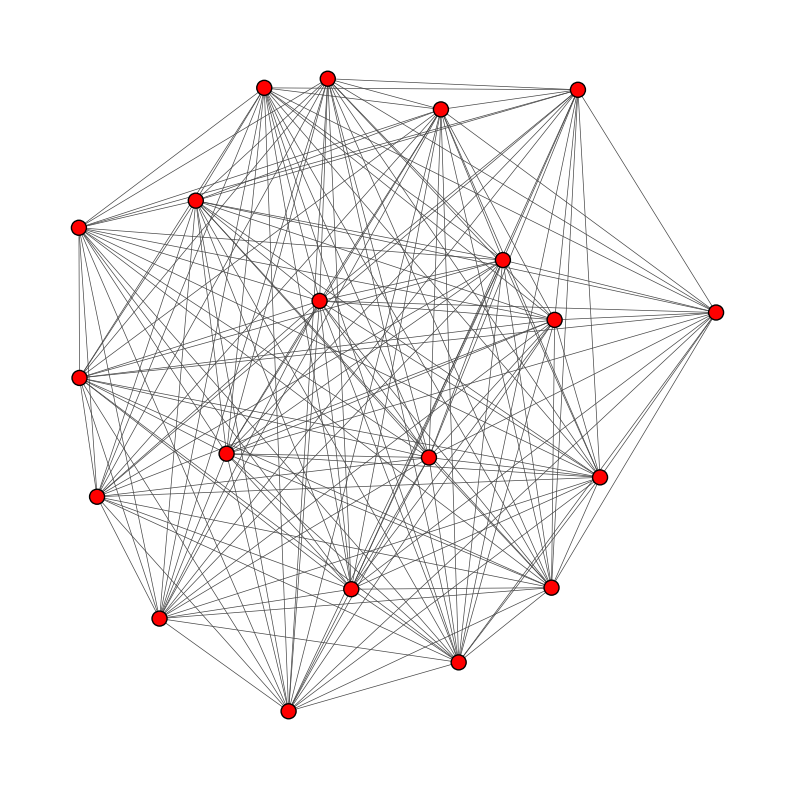

In [27]:
# plot
fig, ax = plt.subplots(figsize=(10,10))

plot(
    business_graph_1,
    vertex_size=15,
    edge_width=0.5,
    target=ax
)

plt.show()

#### Nodes and Edges

In [28]:
# Get a list of all edges and their weights in the graph
edges_with_weights_1 = business_graph_1.get_edgelist()
edge_weights_1 = business_graph_1.es['weight']

# Combine edge information into a list of tuples
edges_with_weights_1 = [(edges_with_weights_1[i][0], edges_with_weights_1[i][1], edge_weights_1[i]) for i in range(len(edges_with_weights_1))]

print(edges_with_weights_1)
# start node, ending node, weight

[(0, 1, 22.0), (0, 2, 19.0), (0, 3, 12.0), (0, 4, 29.0), (0, 5, 22.0), (0, 6, 76.0), (0, 7, 22.0), (0, 8, 11.0), (0, 9, 17.0), (0, 10, 11.0), (0, 11, 4.0), (0, 12, 10.0), (0, 13, 21.0), (0, 14, 6.0), (0, 15, 3.0), (0, 16, 4.0), (0, 17, 18.0), (0, 19, 12.0), (1, 2, 104.0), (1, 3, 17.0), (1, 4, 70.0), (1, 5, 57.0), (1, 6, 30.0), (1, 7, 43.0), (1, 8, 34.0), (1, 9, 41.0), (1, 10, 25.0), (1, 11, 35.0), (1, 12, 19.0), (1, 13, 34.0), (1, 14, 40.0), (1, 15, 32.0), (1, 16, 19.0), (1, 17, 13.0), (1, 18, 10.0), (1, 19, 33.0), (2, 3, 56.0), (2, 4, 73.0), (2, 5, 44.0), (2, 6, 14.0), (2, 7, 82.0), (2, 8, 24.0), (2, 9, 46.0), (2, 10, 16.0), (2, 11, 26.0), (2, 12, 24.0), (2, 13, 51.0), (2, 14, 39.0), (2, 15, 9.0), (2, 16, 25.0), (2, 17, 14.0), (2, 18, 12.0), (2, 19, 48.0), (3, 4, 62.0), (3, 5, 37.0), (3, 7, 46.0), (3, 8, 34.0), (3, 9, 33.0), (3, 10, 34.0), (3, 11, 28.0), (3, 12, 23.0), (3, 13, 26.0), (3, 14, 34.0), (3, 15, 8.0), (3, 16, 28.0), (3, 17, 12.0), (3, 18, 10.0), (3, 19, 21.0), (4, 5, 96.0),

In [29]:
edges_1 = pd.DataFrame(edges_with_weights_1, columns = ['from', 'to', 'weights'])

In [30]:
edges_1.head()

from  to  weights
0     0   1     22.0
1     0   2     19.0
2     0   3     12.0
3     0   4     29.0
4     0   5     22.0

In [31]:
edges_1.groupby(["from","to", "weights"]).size()

from  to  weights
0     1   22.0       1
      2   19.0       1
      3   12.0       1
      4   29.0       1
      5   22.0       1
                    ..
16    18  36.0       1
      19  27.0       1
17    18  8.0        1
      19  9.0        1
18    19  2.0        1
Length: 182, dtype: int64

In [32]:
# connections
print(business_graph_1)

IGRAPH UNW- 20 182 --
+ attr: id (v), name (v), weight (e)
+ edges (vertex names):
         Geno's Steaks --   Amada,   Zahav,   HipCityVeg,   Village Whiskey,
Parc,   Jim's South St,   Federal Donuts,   Honey's Sit-N-Eat,   Good Dog Bar,
Nom Nom Ramen,   Khyber Pass Pub,   Osteria,   Sabrina's Café,   Butcher and
Singer,   Fogo de Chao,   Cantina Dos Segundos,   John's Roast Pork,   Tria
Cafe Wash West
                 Amada --   Geno's Steaks,   Zahav,   HipCityVeg,   Village
Whiskey,   Parc,   Jim's South St,   Federal Donuts,   Honey's Sit-N-Eat,
Good Dog Bar,   Nom Nom Ramen,   Khyber Pass Pub,   Osteria,   Sabrina's Café,
Butcher and Singer,   Fogo de Chao,   Cantina Dos Segundos,   John's Roast
Pork,   El Camino Real,   Tria Cafe Wash West
                 Zahav --   Geno's Steaks,   Amada,   HipCityVeg,   Village
Whiskey,   Parc,   Jim's South St,   Federal Donuts,   Honey's Sit-N-Eat,
Good Dog Bar,   Nom Nom Ramen,   Khyber Pass Pub,   Osteria,   Sabrina's Café,
Butcher and Si

#### Network and node characteristics

In [33]:
# Density: The proportion of present edges from all possible edges in the network
edge_density_1 = business_graph_1.density(loops=False)
print(f"Density: {edge_density_1:0.4f}")
print(f"or... {business_graph_1.ecount() / (business_graph_1.vcount() * (business_graph_1.vcount() - 1)):0.4f}")

# dataframe density
density_df.loc[len(density_df)] = {"Metric type": "metric1" , "Density": edge_density_1}

Density: 0.9579
or... 0.4789


In [34]:
# Diameter: longest geodesic distance (eccentricity) between any two vertices in the network
diameter_undirected_1 = business_graph_1.diameter(directed=False, weights=None)
print(f"Undirected diameter: {diameter_undirected_1}")
diameter_weighted_1 = business_graph_1.diameter(directed=False, weights="weight")
print(f"Weighted undirected diameter: {diameter_weighted_1}")

# dataframe diameter
diameter_df.loc[len(diameter_df)] = {"Metric type": "metric1" , "Undirected diameter": diameter_undirected_1, "Weighted undirected diameter": diameter_weighted_1}

Undirected diameter: 2
Weighted undirected diameter: 24.0


In [35]:
# Node degrees: how many edges are connected to a node
# The mode="ALL" parameter means that it calculates the total degree, considering both incoming and outgoing edges for directed graphs
deg_1 = business_graph_1.degree(mode="ALL")

# plot the network with node size proportional to degree
node_deg_1 = pd.DataFrame({"name": business_graph_1.vs["name"], "node degrees": deg_1}).sort_values("node degrees", ascending=False)
node_deg_1['name'] = node_deg_1['name'].str.replace('\n\n','')
node_deg_1

name  node degrees
10         Nom Nom Ramen            19
5                   Parc            19
1                  Amada            19
9           Good Dog Bar            19
7         Federal Donuts            19
19   Tria Cafe Wash West            19
4        Village Whiskey            19
2                  Zahav            19
6         Jim's South St            18
8      Honey's Sit-N-Eat            18
3             HipCityVeg            18
12               Osteria            18
13        Sabrina's Café            18
14    Butcher and Singer            18
16  Cantina Dos Segundos            18
17     John's Roast Pork            18
0          Geno's Steaks            18
11       Khyber Pass Pub            17
18        El Camino Real            17
15          Fogo de Chao            16

Text(0.5, 1.0, 'Histogram of node degree')

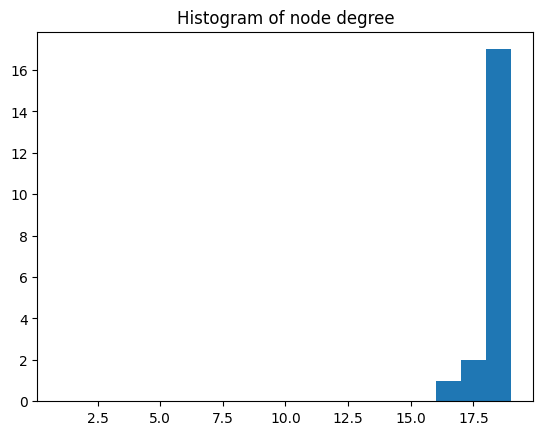

In [36]:
# check the distribution of the degrees
ax = plt.hist(deg_1, bins=range(1, business_graph_1.vcount()))
plt.title("Histogram of node degree")

In [37]:
# Closeness: proximity of a node to all other nodes in a network.)
# Inverse of the node’s average geodesic distance to others in the network.
# can also be calculated with weights

closeness_1 = business_graph_1.closeness(mode="ALL", weights=None)

# <node, closeness> pairs
close_1 = pd.DataFrame({"name": business_graph_1.vs["name"], "closeness": closeness_1}).sort_values("closeness", ascending=False)
close_1['name'] = close_1['name'].str.replace('\n\n','')
close_1

name  closeness
10         Nom Nom Ramen   1.000000
5                   Parc   1.000000
1                  Amada   1.000000
9           Good Dog Bar   1.000000
7         Federal Donuts   1.000000
19   Tria Cafe Wash West   1.000000
4        Village Whiskey   1.000000
2                  Zahav   1.000000
6         Jim's South St   0.950000
8      Honey's Sit-N-Eat   0.950000
3             HipCityVeg   0.950000
12               Osteria   0.950000
13        Sabrina's Café   0.950000
14    Butcher and Singer   0.950000
16  Cantina Dos Segundos   0.950000
17     John's Roast Pork   0.950000
0          Geno's Steaks   0.950000
11       Khyber Pass Pub   0.904762
18        El Camino Real   0.904762
15          Fogo de Chao   0.863636

In [38]:
# Betweenness (centrality based on a broker position connecting others) - Number of geodesics that pass through the node or the edge. The higher, the more important the node is.
betweenness_1 = business_graph_1.betweenness(directed=True, weights=None)

# <node, betweenness> pairs
between_1 = pd.DataFrame({"name": business_graph_1.vs["name"], "betweenness": betweenness_1}).sort_values("betweenness", ascending=False)
between_1['name'] = between_1['name'].str.replace('\n\n','')
between_1

name  betweenness
10         Nom Nom Ramen     0.479248
5                   Parc     0.479248
1                  Amada     0.479248
9           Good Dog Bar     0.479248
7         Federal Donuts     0.479248
19   Tria Cafe Wash West     0.479248
4        Village Whiskey     0.479248
2                  Zahav     0.479248
6         Jim's South St     0.423693
3             HipCityVeg     0.423693
16  Cantina Dos Segundos     0.423693
17     John's Roast Pork     0.423693
13        Sabrina's Café     0.361601
18        El Camino Real     0.361601
0          Geno's Steaks     0.361601
14    Butcher and Singer     0.353758
8      Honey's Sit-N-Eat     0.287582
12               Osteria     0.287582
11       Khyber Pass Pub     0.228758
15          Fogo de Chao     0.228758

Text(0.5, 1.0, 'Histogram of the betweenness for edges')

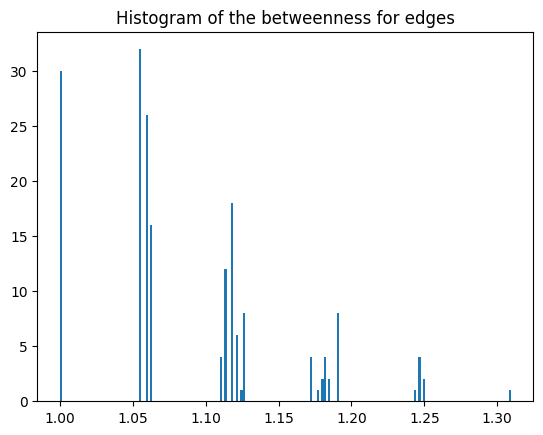

In [39]:
# we can also calculate the betweenness for edges
# measures the importance of edges in facilitating the flow of information between nodes.
edge_betweenness_1 = business_graph_1.edge_betweenness(directed=True, weights=None)

# check the distribution of the betweenness for edges
ax = plt.hist(edge_betweenness_1, bins=200)
plt.title("Histogram of the betweenness for edges")

In [40]:
# Average path length: the mean of the shortest distance between each pair of nodes in the network.
mean_dist_undirected_1 = business_graph_1.average_path_length(directed=False)
print(f"Average path length (undirected)= {mean_dist_undirected_1:.3f}")

Average path length (undirected)= 1.042


In [41]:
homophily_1 = business_graph_1.assortativity_degree(directed=False)

print(f"All network = {homophily_1:.3f}")

homophily_df.loc[len(homophily_df)] = {"Metric type": "metric1" , "Homophily": homophily_1}

All network = -0.097
